Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)
Ciclo Recesión 70-81 ignorado (fuera de rango)
Ciclo Crisis 82-84 ignorado (fuera de rango)


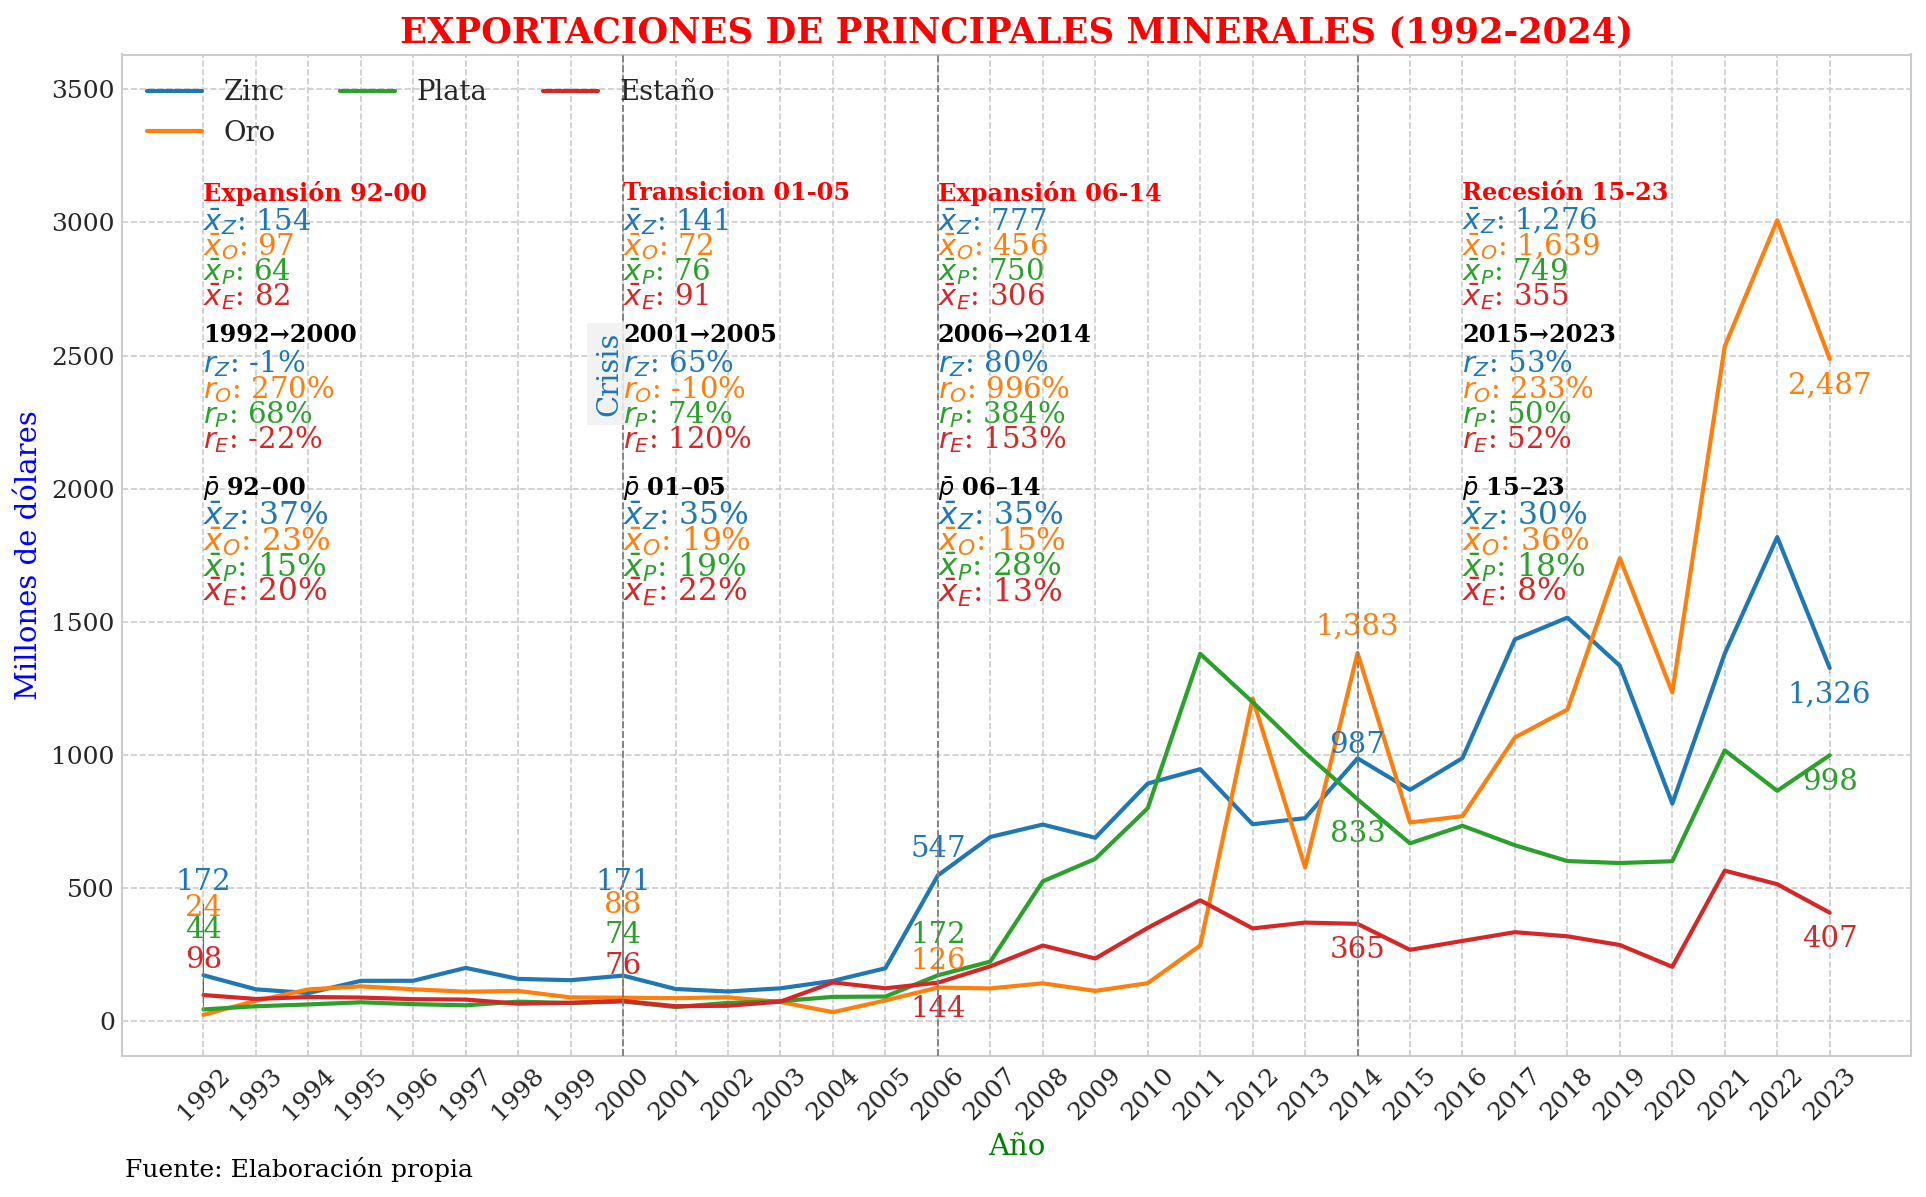

In [21]:
# ───────────────────────────── IMPORTS ──────────────────────────────
import sys, os, sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))          # utilidades propias
from func_auxiliares.graficos_utils import (
    add_hitos, add_cycle_means_multi, add_year_value_annotations,
    add_period_growth_annotations_multi, add_participation_cycle_boxes,
    init_base_plot, set_style, adjust_annot_years, adjust_cycles,
    adjust_periods
)
from func_auxiliares.config import *

# ─────────────────────── 1. CONFIGURACIÓN GENERAL ───────────────────
output_dir = "../../../../assets/tesis/serie_completa/minerales"
os.makedirs(output_dir, exist_ok=True)

set_style()

# ───────────────────────── 2. CARGA DE DATOS ────────────────────────
with sqlite3.connect(DB_PATH) as conn:
    df = (
        pd.read_sql(
            "SELECT * FROM exportaciones_minerales_totales WHERE año > 1991",
            conn
        )
        .set_index('año')
        .sort_index()
    )

# Cols de valor (miles USD) → millones USD
valor_cols = [c for c in df.columns if c.endswith('_valor')]
df[valor_cols] = df[valor_cols] / 1000            # ⇢ millones USD
df['total'] = df[valor_cols].sum(axis=1)

# ──────────────── 3. COMPONENTES Y PREPARACIÓN ──────────────────────
componentes = [
    ("zinc_valor", "Zinc"),
    ("oro_valor", "Oro"),
    ("plata_valor", "Plata"),
    ("estaño_valor", "Estaño")
]
component_cols = ['zinc_valor', 'oro_valor', 'plata_valor', 'estaño_valor']

color_map = {
    'zinc_valor':   '#1f77b4',
    'oro_valor':    '#ff7f0e',
    'plata_valor':  '#2ca02c',
    'estaño_valor': '#d62728',
}

abbr_map = {
    'zinc_valor': 'Z', 
    'oro_valor': 'O', 
    'plata_valor': 'P', 
    'estaño_valor': 'E'}
CYCLES   = adjust_cycles(df, CYCLES)
cycle_stats = {
    name: df.loc[period, component_cols].mean().to_dict()
    for name, period in CYCLES.items()
}
periodos = adjust_periods(df, periodos_tasas)

# ───────────── 4. OFFSETS Y UTILIDADES (POSICIONAMIENTO) ────────────
hitos_v      = {
    1982: "Crisis", 1986: "Expansión", 2000: "Crisis",
    2006: "Expansión", 2014: "Recesión"
}
hitos_offset = {a: 0.82 for a in hitos_v}

medias_offset = {
    "Expansión 92-00":  (1992, 1),
    "Transicion 01-05": (2000, 1),
    "Expansión 06-14":  (2006, 1),
    "Recesión 15-23":   (2016, 1),
}

anot_years = [1992, 2000, 2006, 2014, 2023]
annotation_offsets = {
    'zinc_valor':  {1992: (0, 350), 2000: (0, 350), 2006: (0, 100), 2014: (0,  50), 2023: (0, -100)},
    'oro_valor':   {1992: (0, 400), 2000: (0, 350), 2006: (0, 100), 2014: (0, 100), 2023: (0, -100)},
    'plata_valor': {1992: (0, 300), 2000: (0, 250), 2006: (0, 150), 2014: (0,-130), 2023: (0, -100)},
    'estaño_valor':{1992: (0, 130), 2000: (0, 130), 2006: (0,-100), 2014: (0,-100), 2023: (0, -100)}
}

annotation_tasas_offsets = {
    "1992-2000": (1992, 0.83),
    "2001-2005": (2000, 0.83),
    "2006-2014": (2006, 0.83),
    "2015-2023": (2016, 0.83),
}
participation_offsets = {
    "1992-2000": (1992, 0.65),
    "2001-2005": (2000, 0.65),
    "2006-2014": (2006, 0.65),
    "2015-2023": (2016, 0.65),
}

# ────────────────────────── 5. GRÁFICO ──────────────────────────────
fig, ax = init_base_plot(
    df=df,
    series=componentes,
    colors=color_map,
    title="EXPORTACIONES DE PRINCIPALES MINERALES (1992-2024)",
    xlabel="Año",
    ylabel="Millones de dólares",
    source_text="Fuente: Elaboración propia"
)

# ─────────────── 6. HITOS Y ANOTACIONES EXTRA ──────────────────────
add_hitos(ax, df.index, hitos_v, hitos_offset, line_kwargs={'linewidth': 0.9})

line_spacing = ax.get_ylim()[1] * 0.03
add_cycle_means_multi(
    ax, cycle_stats, medias_offset,
    abbr_map, color_map, line_spacing
)

add_year_value_annotations(
    ax, df, anot_years,
    component_cols, annotation_offsets,
    color_map, arrow_lw=0.5
)

df_g = df.replace(0, np.nan)
add_period_growth_annotations_multi(
    ax, df_g, periodos,
    component_cols, annotation_tasas_offsets,
    color_map, abbr_map
)

add_participation_cycle_boxes(
    ax, df, periodos,
    component_cols,         # componentes
    'total',                # total de exportaciones tradicionales
    participation_offsets,
    abbr_map=abbr_map,
    colors=color_map
)

# ──────────────── 7. AJUSTES FINALES Y SALIDA ──────────────────────
y_min, y_max = ax.get_ylim()
ax.set_ylim(y_min * 1.05, y_max * 1.15)

plt.savefig(os.path.join(output_dir, "exportaciones_minerales_valores.png"))
plt.show()


In [19]:
abbr_map

{'zinc_valor': 'Z', 'oro_valor': 'O', 'plata_valor': 'P', 'estaño_valor': 'E'}